<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-comparison-48.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>Results and Comparisons</strong>
</h1>

In [1]:
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Brain_Alzheimer_Classification


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-import-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Imports
</h1>


In [2]:
# Suppress user and future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# imports
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json


# repository imports
import utils.Grad_cam as GC
from models import def_models
from utils import utils_funcs

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-gpu-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Define Definition
</h1>

In [3]:
# check if there is a CUDA device available 
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()

torch.cuda.is_available(): True
device: cuda:0


<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-alzheimer-100.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>The Data</strong>
</h1>

**Load The Data**

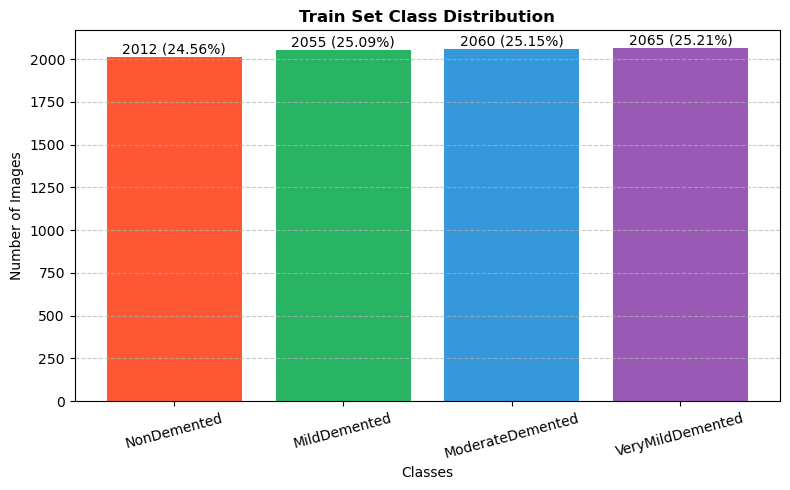

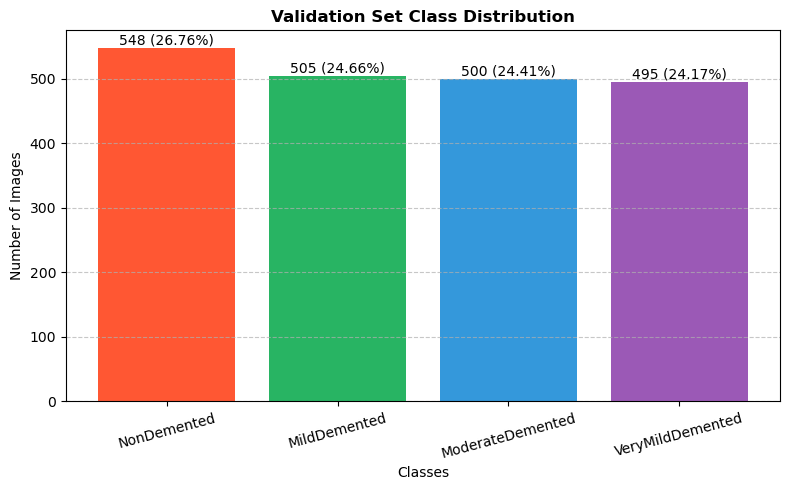

In [4]:
batch_size = 64
height = 224
width = 224

train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

utils_funcs.calculate_statistics(train_set, 'Train Set')
utils_funcs.calculate_statistics(validation_set, 'Validation Set')

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4,pin_memory=True)

**Alzheimer Severity Data**

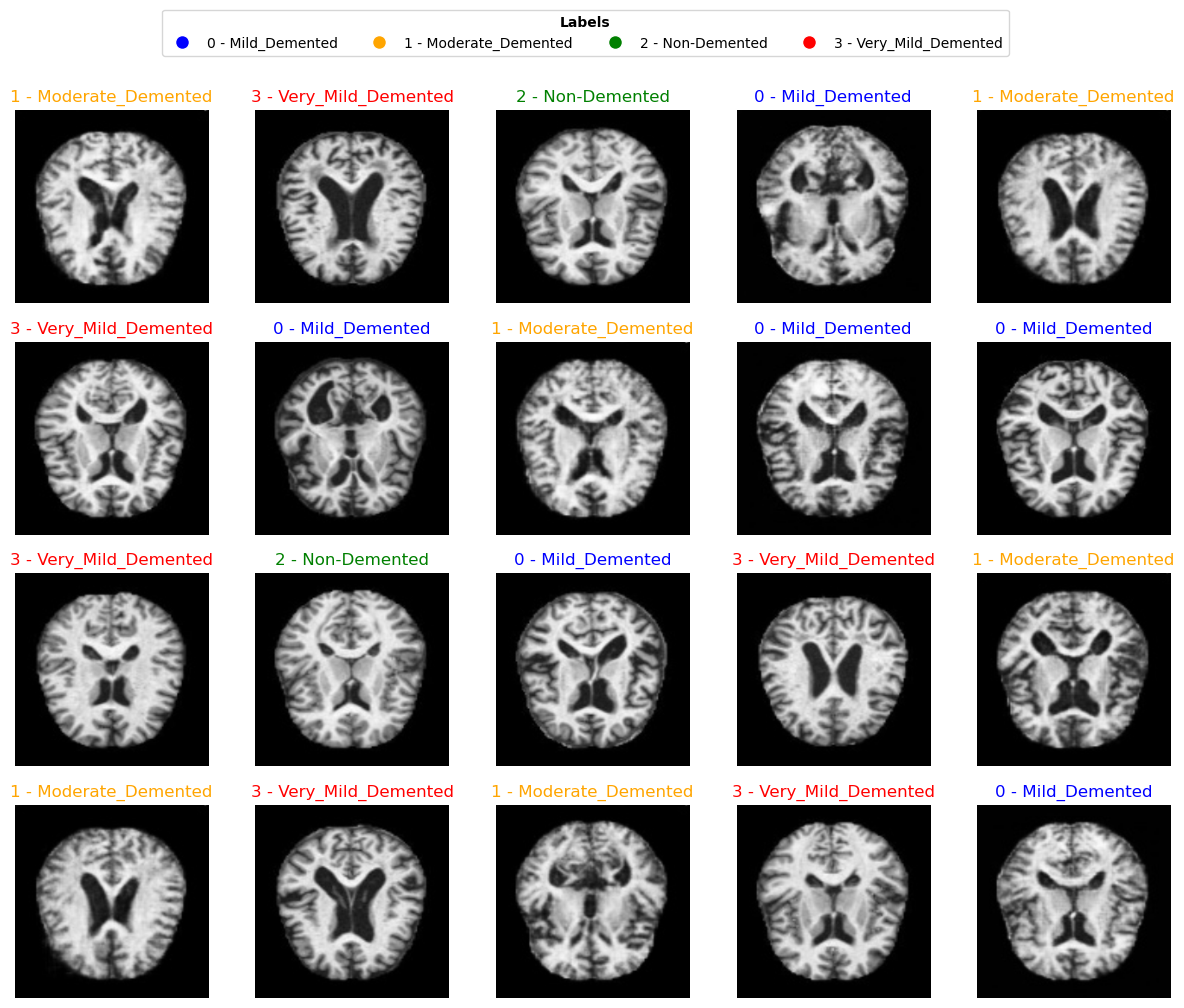

In [5]:
utils_funcs.plot_random_images(train_set,20)

<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-kawaii-dinosaur-48.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>DinoV2 Fine Tuned</strong>
</h1>


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-process-100.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Define the model
</h1>

In [6]:
input_channels = 3
output_channels = 4

dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# make the model
model = def_models.DINOv2(DINOv2_backbone=dino_v2_model, output_channels=output_channels).to(device)

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Retrieve fined-tuned Model
</h1>

In [7]:
# retrieve the fined-tuned model
model_path = './checkpoints/DINOv2_074712_09102024/DINOv2_140224_09102024_train_0.0121_val_0.0937.pth'
checkpoint = torch.load(model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Model statistics
</h1>

In [8]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

model  DINOv2  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
            Linear-6             [-1, 257, 384]         147,840
           Dropout-7             [-1, 257, 384]               0
   MemEffAttention-8             [-1, 257, 384]               0
        LayerScale-9             [-1, 257, 384]               0
        LayerNorm-10             [-1, 257, 384]             768
           Linear-11            [-1, 257, 1536]         591,360
             GELU-12            [-1, 257, 1536]               0
          Dropout-13            [-1, 257, 1536]               0
           Li

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-matrix-60.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Confusion Matrix
</h1>

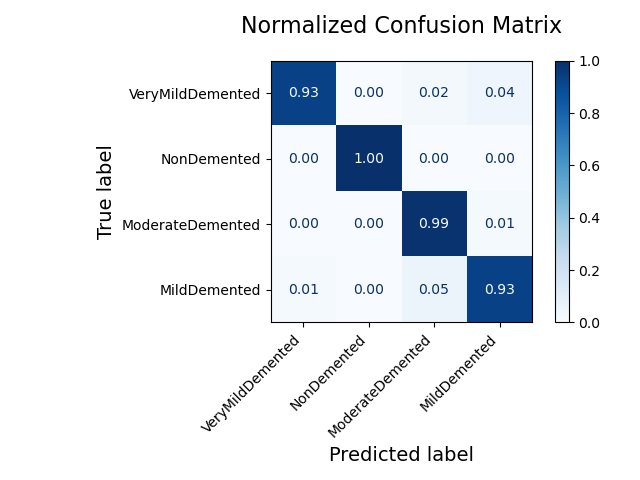

In [9]:
utils_funcs.load_and_display_image(model_name,'confusion_matrix')

**Visualize T-SNE**

In [9]:
# utils_funcs.visualize_dino_tsne(model.dino_backbone, dino_validationloader, device, perplexity=10, learning_rate=1000)
# #TODO: make it so we only need to bring the image here

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Training Curve of the best fined-tuned model
</h1>

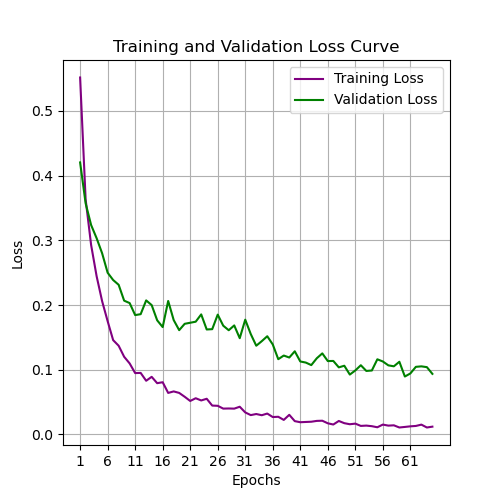

In [10]:
utils_funcs.load_and_display_image(model_name,'plot_loss_curve')

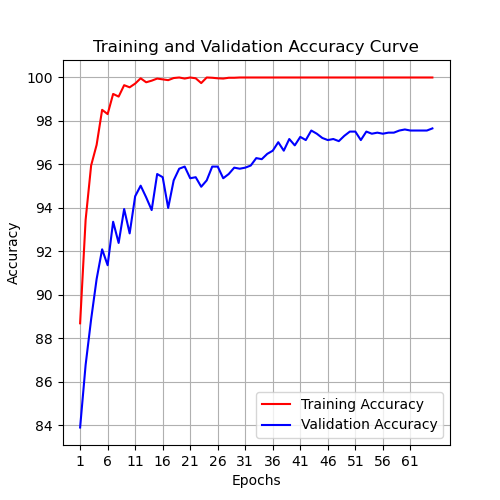

In [11]:
utils_funcs.load_and_display_image(model_name,'plot_accuracy_curve')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Accuracy
</h1>

In [12]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 94.527%


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-source-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GradCAM
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    DinoV2 under attack - FGSM,PGD
</h1>

In [7]:

train_epsilon = epsilon = .005
alpha = 0.01
adv_weight = 0.5
num_iter = 5

model_path = './checkpoints/DINOv2_atk_225702_10102024/DINOv2_atk_060120_11102024_train_0.3432_val_0.7326.pth'
checkpoint = torch.load(model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])


<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Accuracy
</h1>

In [8]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy on regular test set: {:.3f}%".format(test_accuracy))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='fgsm',epsilon=train_epsilon)
print("Test accuracy on adversial attacks using FGSM method: {:.3f}%".format(test_accuracy_adversial_attk))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='pgd',epsilon=train_epsilon, alpha=alpha, num_iter=num_iter)
print("Test accuracy on adversial attacks using PGD method: {:.3f}%".format(test_accuracy_adversial_attk))

Test accuracy on regular test set: 84.050%
Test accuracy on adversial attacks using FGSM method: 39.093%
Test accuracy on adversial attacks using PGD method: 57.389%


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Training Curve
</h1>

<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/deep-learning.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>Model2 Fine Tuned</strong>
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-process-100.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Define the model
</h1>

In [ ]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

# Load a pre-trained ResNet34 model
ResNet_backbone_model = torchvision.models.resnet34(pretrained=True)

# Create ResNet34 model with FC layers before the output
model = def_models.ResNet(ResNet_backbone=ResNet_backbone_model, output_channels=output_channels).to(device)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Retrieve fined-tuned Model
</h1>

In [ ]:
# retrieve the fined-tuned model
model_path = './checkpoints/....pth'
checkpoint = torch.load(model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Model statistics
</h1>

In [ ]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

model  DINOv2  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
            Linear-6             [-1, 257, 384]         147,840
           Dropout-7             [-1, 257, 384]               0
   MemEffAttention-8             [-1, 257, 384]               0
        LayerScale-9             [-1, 257, 384]               0
        LayerNorm-10             [-1, 257, 384]             768
           Linear-11            [-1, 257, 1536]         591,360
             GELU-12            [-1, 257, 1536]               0
          Dropout-13            [-1, 257, 1536]               0
           Li

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-matrix-60.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Confusion Matrix
</h1>

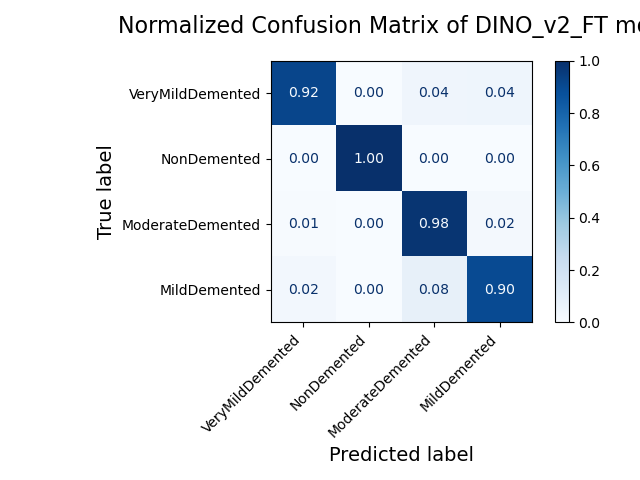

In [ ]:
utils_funcs.load_and_display_image(model_name,'confusion_matrix')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Training Curve of the best fined-tuned model
</h1>

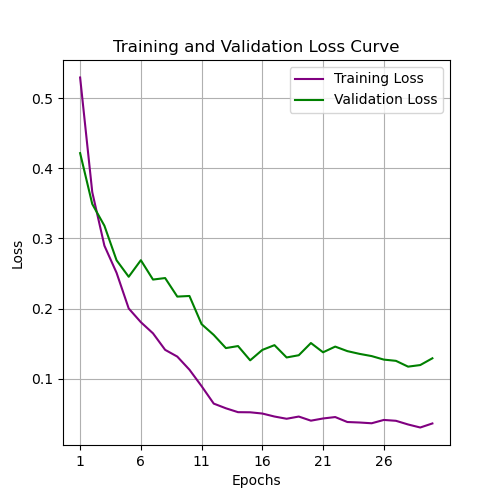

In [ ]:
utils_funcs.load_and_display_image(model_name,'plot_loss_curve')

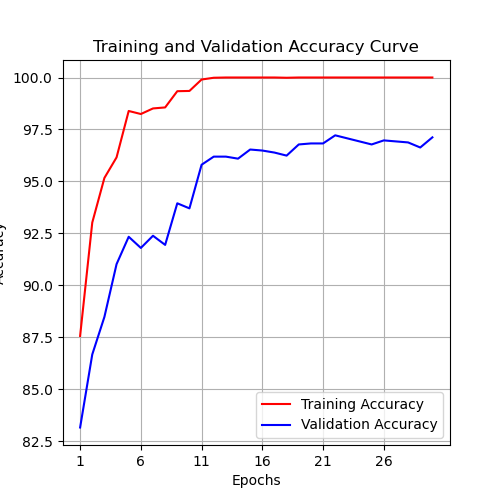

In [ ]:
utils_funcs.load_and_display_image(model_name,'plot_accuracy_curve')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Accuracy
</h1>

In [ ]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 94.371%


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-source-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GradCAM
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    DinoV2 under attack - FGSM,PGD
</h1>

In [ ]:
train_epsilon = epsilon = .005
alpha = 0.01
adv_weight = 0.5
num_iter = 5

model_path = './checkpoints/......pth'
checkpoint = torch.load(model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Accuracy
</h1>

In [ ]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy on regular test set: {:.3f}%".format(test_accuracy))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='fgsm',epsilon=train_epsilon)
print("Test accuracy on adversial attacks using FGSM method: {:.3f}%".format(test_accuracy_adversial_attk))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='pgd',epsilon=train_epsilon, alpha=alpha, num_iter=num_iter)
print("Test accuracy on adversial attacks using PGD method: {:.3f}%".format(test_accuracy_adversial_attk))

Test accuracy on regular test set: 84.050%
Test accuracy on adversial attacks using FGSM method: 39.093%
Test accuracy on adversial attacks using PGD method: 57.389%


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Training Curve
</h1>

<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/deep-learning_2.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>Efficientnet_b0 Fine Tuned</strong>
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-process-100.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Define the model
</h1>

In [6]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

# Load a pre-trained EfficientNet-B0 model
EfficientNet_backbone_model = torchvision.models.efficientnet_b0(pretrained=True)

# Freeze EfficientNet-B0 layers
for param in EfficientNet_backbone_model.parameters():
    param.requires_grad = True

# Create EfficientNet-B4 model with FC layers before the output
model = def_models.EfficientNet(EfficientNet_backbone=EfficientNet_backbone_model, output_channels=output_channels).to(device)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Retrieve fined-tuned Model
</h1>

In [7]:
# retrieve the fined-tuned model
model_path = f"./checkpoints/EfficientNet_083104_17102024/EfficientNet_092843_17102024_train_0.0044_val_0.0401.pth"
checkpoint = torch.load(model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Architecture statistics
</h1>

In [8]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

model  EfficientNet  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      B

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-matrix-60.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Confusion Matrix
</h1>

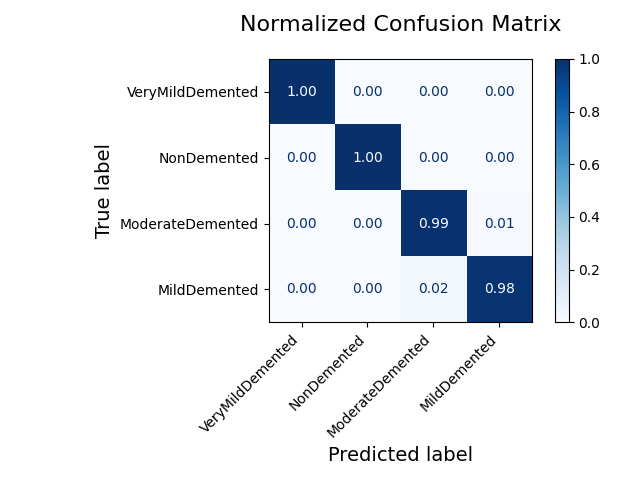

In [8]:
utils_funcs.load_and_display_image(model_name,'confusion_matrix')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Training Curve of the best fined-tuned model
</h1>

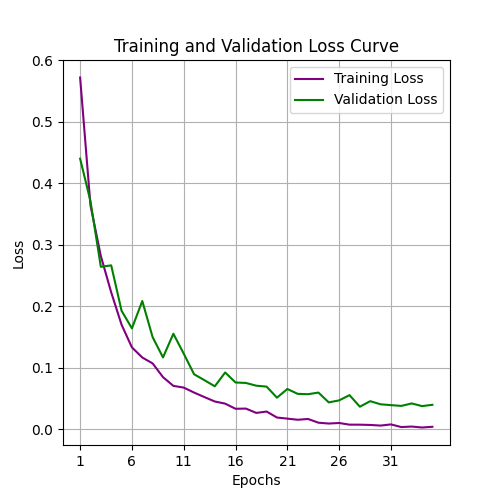

In [9]:
utils_funcs.load_and_display_image(model_name,'plot_loss_curve')

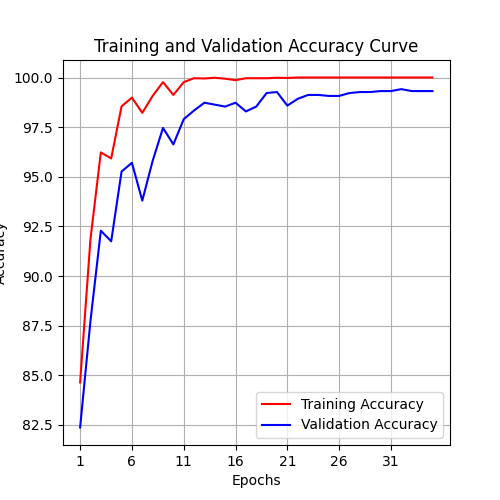

In [10]:
utils_funcs.load_and_display_image(model_name,'plot_accuracy_curve')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Accuracy
</h1>

In [20]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 98.905%


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-source-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GradCAM
</h1>

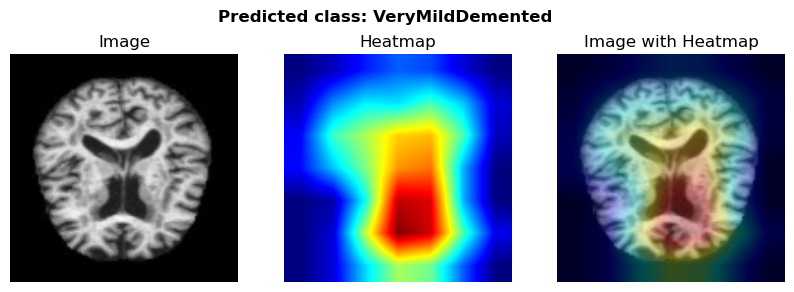

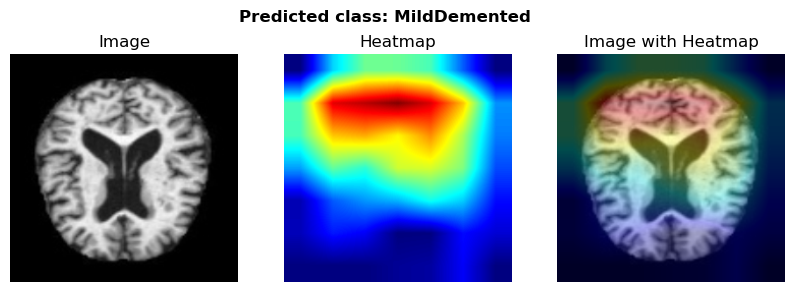

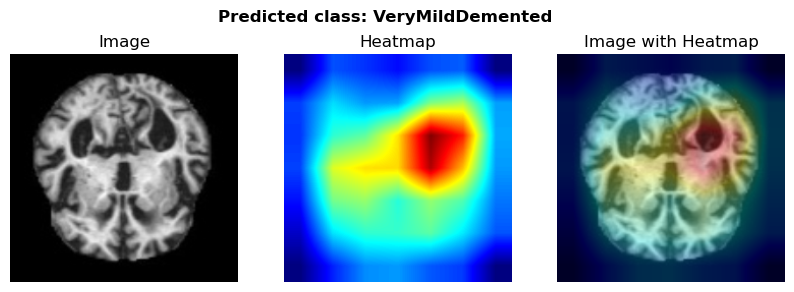

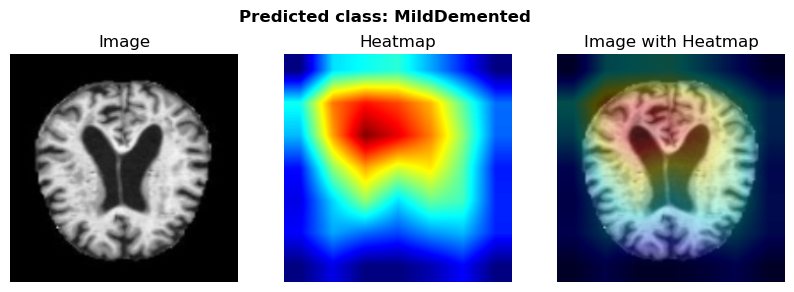

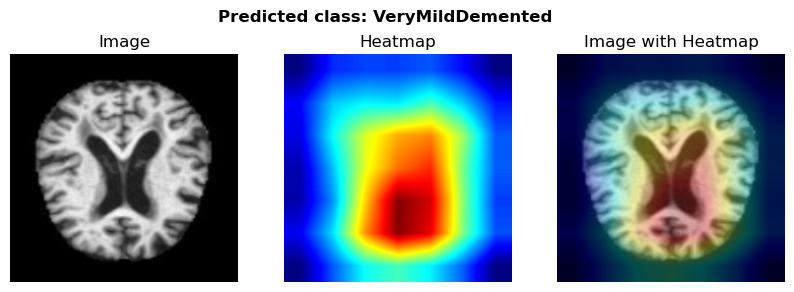

In [14]:
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=4,pin_memory=True)

# Assuming you have your EfficientNet model loaded - take the last conv layer
layer = model.EfficientNet_backbone.features[-1][0]

# Initialize the Grad-CAM with your model
grad_cam = GC.Grad_cam(model = model, last_conv_layer = layer)

GC.display_correct_grad_cam_images(testloader, grad_cam, device, num_images_to_show=5)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    EfficientnetB0 under attack - FGSM,PGD
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Training Curve
</h1>